## Context

In this notebook, we will create a deep neural network for image classification. The classification to be realized won't be pixel-wise but a patch based approach. That means, for a given image, it will be patched and each patch will be fed into the model to determine the class of the given patch. By doing so, we can efficiently classify images. The dataset to be used is provided by [Eurosat](https://github.com/phelber/EuroSAT?tab=readme-ov-file).




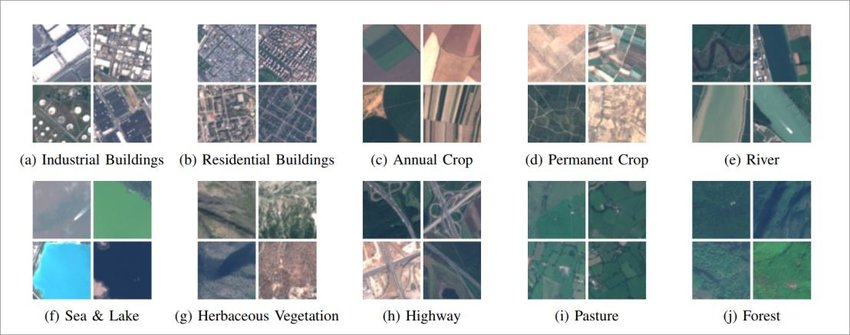

## Download the data

This [tutorial](https://realpython.com/python-download-file-from-url/) shows how to download files from url using python. We will use `urllib` to download the zipped dataset.

In [ ]:
from urllib.request import urlretrieve
import os
import zipfile

In [ ]:
save_folder = "/content/drive/MyDrive/Deep Learning For EO Udemy Training/datasets" # Path to save the data
file_url = "https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip" # Url of the data to be downloaded
path, _ = urlretrieve(file_url, os.path.join(save_folder, "EuroSAT_RGB.zip")) # Download the file and get the path where it has been saved
zipfile.ZipFile(path, "r").extractall(save_folder) # Extract the data to the folder

In [ ]:
# Inspectons les données
os.listdir(save_folder)

['EuroSAT_RGB.zip', 'EuroSAT_RGB']

In [ ]:
os.listdir(save_folder+"/EuroSAT_RGB")

['Highway',
 'AnnualCrop',
 'SeaLake',
 'HerbaceousVegetation',
 'Industrial',
 'Residential',
 'PermanentCrop',
 'Pasture']

So, the dataset contains many patches of each class regrouped in folders. Let's see how many images each class contains

In [ ]:
data = dict()
for folder in os.listdir(save_folder+"/EuroSAT_RGB"):
  data[folder] = len(os.listdir(save_folder+"/EuroSAT_RGB/"+folder))
data

{'Highway': 1229,
 'AnnualCrop': 3000,
 'SeaLake': 3000,
 'HerbaceousVegetation': 3000,
 'Industrial': 2500,
 'Residential': 3000,
 'PermanentCrop': 2500,
 'Pasture': 2000}

In [ ]:
def get_numbers(data_dict):
  numbers = []
  for key in data_dict:
    numbers.append(data_dict[key])
  return numbers

In [ ]:
print(f"The total number of images is : {sum(get_numbers(data))}")

The total number of images is : 20229


# Model development

## Import libraries

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd
import seaborn as sns


# Tensorflow library tools
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, \
  Flatten, MaxPooling2D, Add, Dropout, ZeroPadding2D, Activation, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform, random_uniform
from tensorflow.keras.callbacks import EarlyStopping
import keras

# Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

## Setup variables

In [2]:
DATA_PATH = "/content/drive/MyDrive/Deep Learning For EO Udemy Training/datasets/EuroSAT_RGB/"
IMG_SIZE = 64
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
RESCALE = 1./255.
N_CLASSES = len(os.listdir(DATA_PATH))

## Dataset preparation

In [3]:
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=DATA_PATH,
    labels='inferred',
    label_mode='int',
    class_names=os.listdir(DATA_PATH),
    color_mode='rgb',
    batch_size=32,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=10,
    validation_split=VALIDATION_SPLIT,
    subset='training'
).prefetch(buffer_size=32).cache()

val_set = tf.keras.utils.image_dataset_from_directory(
    directory=DATA_PATH,
    labels='inferred',
    label_mode='int',
    class_names=os.listdir(DATA_PATH),
    color_mode='rgb',
    batch_size=32,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=10,
    validation_split=VALIDATION_SPLIT,
    subset='validation'
)

Found 20229 files belonging to 8 classes.
Using 16184 files for training.
Found 20229 files belonging to 8 classes.
Using 4045 files for validation.


In [4]:
print("Nombre d'images de validation :", val_set.cardinality().numpy()*BATCH_SIZE)
print("Nombre d'images d'entrainement :", train_set.cardinality().numpy()*BATCH_SIZE)

Nombre d'images de validation : 4064
Nombre d'images d'entrainement : 16192


In [8]:
vars(train_set)

{'_input_dataset': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 '_filename': <tf.Tensor: shape=(), dtype=string, numpy=b''>,
 '_name': None,
 '_variant_tensor_attr': <tf.Tensor: shape=(), dtype=variant, value=<CacheDatasetOp::MemoryDataset>>,
 '_graph_attr': <tensorflow.python.framework.ops.Graph at 0x79b7546f7760>,
 '_options_attr': <tensorflow.python.data.ops.options.Options at 0x79b7519807c0>}

In [ ]:
train_categories = pd.Series(data=train_set.file_paths, name="categorie").map(lambda x: x.split("/")[-2])
val_categories = pd.Series(data=val_set.file_paths, name="categorie").map(lambda x: x.split("/")[-2])

In [ ]:
val_stats = val_categories.value_counts().to_dict()
train_stats = train_categories.value_counts().to_dict()

In [ ]:
val_df = pd.DataFrame(data=val_stats.items(), columns=["categorie", "nombre"])
train_df = pd.DataFrame(data=train_stats.items(), columns=["categorie", "nombre"])

Text(0.5, 1.0, "Nombre d'images par catégorie dans le jeu d'entrainement")

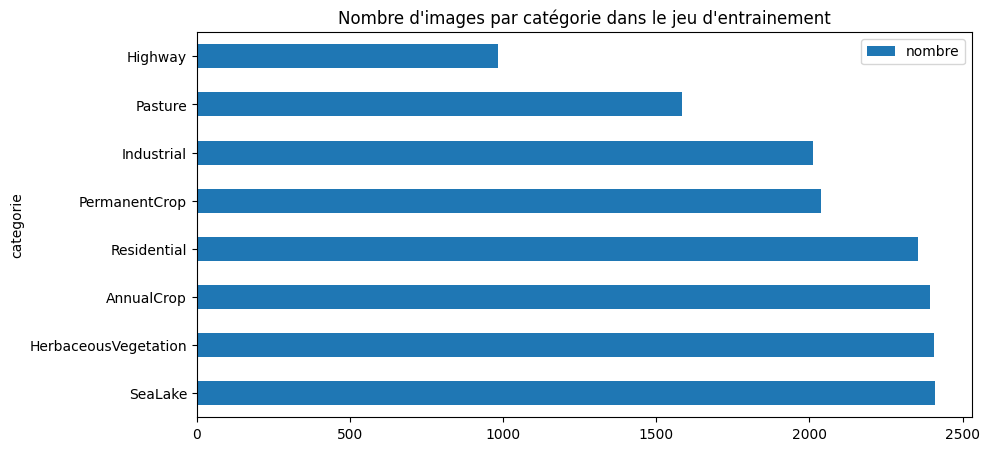

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
train_df.plot(kind="barh", x="categorie", y="nombre", ax=ax)
ax.set_title("Nombre d'images par catégorie dans le jeu d'entrainement")

Text(0.5, 1.0, "Nombre d'images par catégorie dans le jeu de validation")

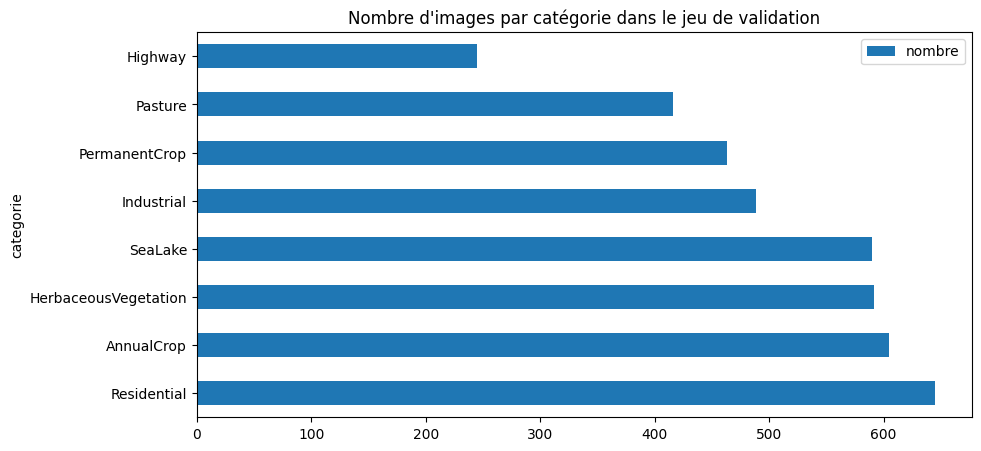

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
val_df.plot(kind="barh", x="categorie", y="nombre", ax=ax1)
ax1.set_title("Nombre d'images par catégorie dans le jeu de validation")

## Visualize some images

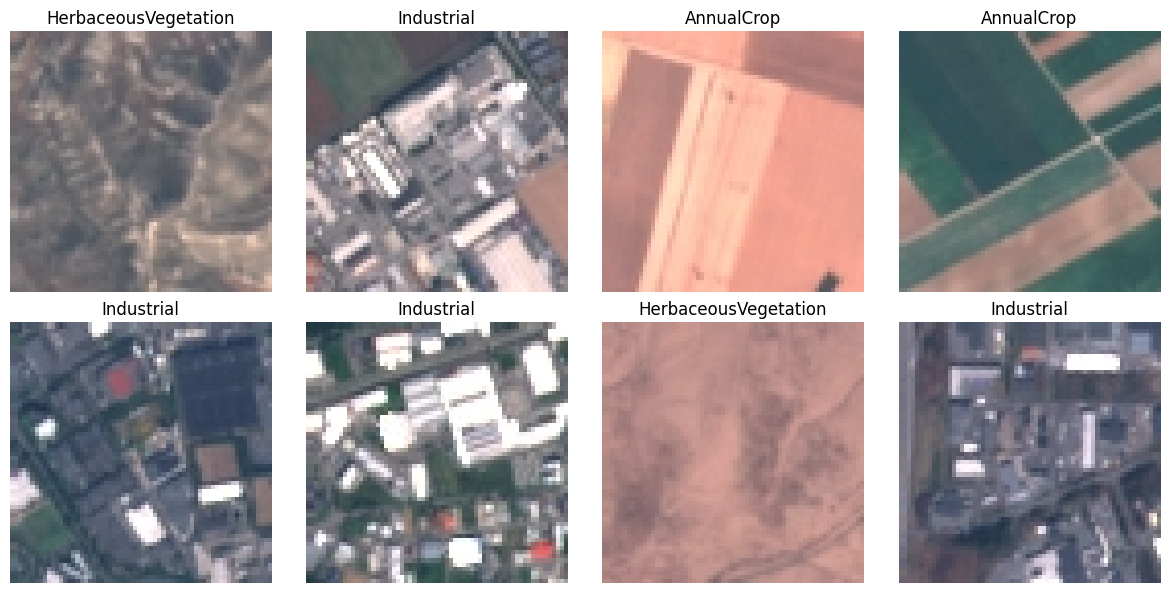

In [ ]:
# Visualizer 8 images du jeu de données d'entrainement
class_names = train_set.class_names

fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# Get images and labels
for images, labels in train_set.take(1):
  imgs = images[:8, ...].numpy()
  lbls = labels[:8, ...].numpy()
  break


for i, ax in enumerate(axs.ravel().tolist()):
  img = np.squeeze(imgs[i]).astype(np.uint8)
  label_index = lbls[i]
  label_name = class_names[label_index]
  ax.imshow(img)
  ax.set_title(label_name)
  ax.axis("off")

fig.tight_layout()

## Architecture des modèles utilisés

In [12]:
def conv_block(input_features, filters, kernel_size):
  """
  A convolutional block for operations
  Conv2D -> BatchNormalization -> ReLU -> MaxPooling2D

  input_features : input features
  filters : number of filters
  kernel_size : kernel size

  return : output features x
  """
  x = Conv2D(filters, kernel_size, activation=None, padding='same')(input_features)
  x = BatchNormalization()(x)
  x = tf.keras.activations.relu(x)
  x = MaxPooling2D(pool_size=2)(x)
  return x

def custom_conv_model(input_shape, num_classes):
  """
  Definition of a custom conv model for images classification

  input shape : shape of the input image
  num_classes : number of classes to be classified

  """

  # Define the input layer
  input_layer = Input(input_shape)

  # Define the architecture
  x = conv_block(input_features=input_layer, filters=25, kernel_size=3)
  x = conv_block(input_features=x, filters=50, kernel_size=3)
  x = conv_block(input_features=x, filters=150, kernel_size=3)

  # Define the output layer
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  out = Dense(num_classes, activation='softmax')(x)

  # Define the model
  model = Model(inputs=input_layer, outputs=out)
  return model

In [15]:
model = custom_conv_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=N_CLASSES)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 25)        700       
                                                                 
 batch_normalization_3 (Bat  (None, 64, 64, 25)        100       
 chNormalization)                                                
                                                                 
 tf.nn.relu_3 (TFOpLambda)   (None, 64, 64, 25)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 25)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 50)        11300 

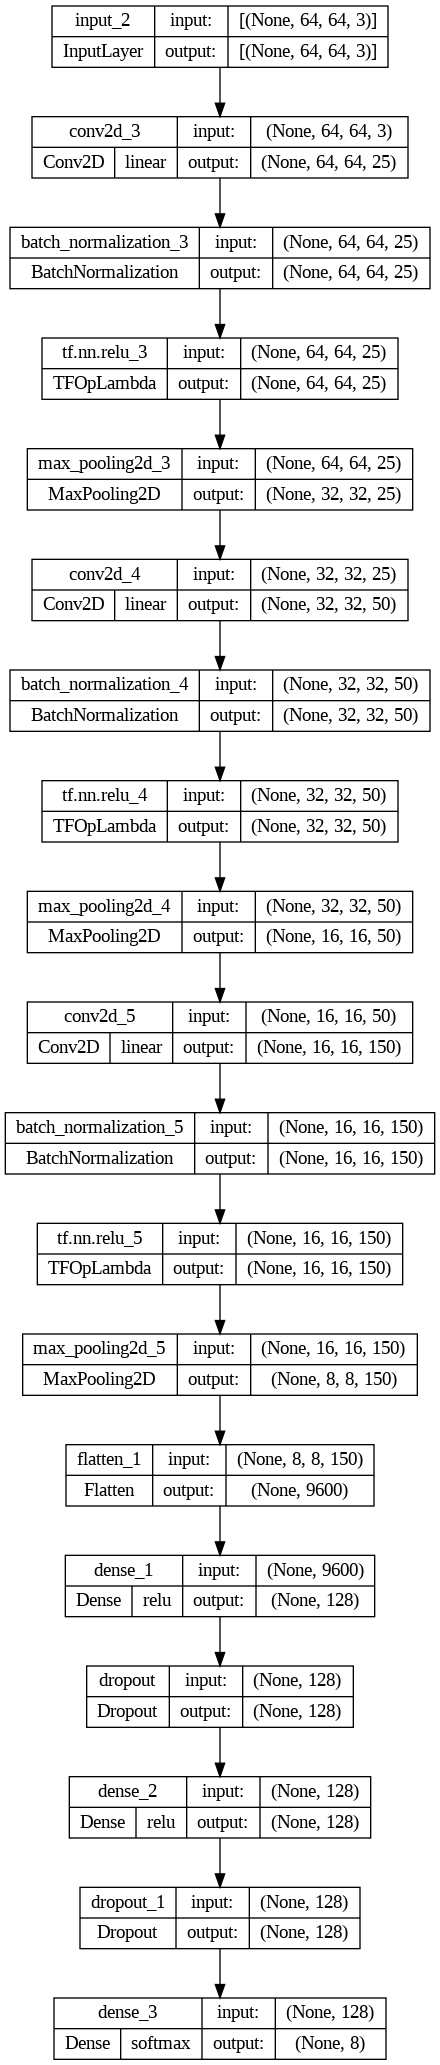

In [16]:
keras.utils.plot_model(model, show_shapes=True, expand_nested=True, show_layer_activations=True)

### Resnet50 implémenté

[Resnet50](https://arxiv.org/pdf/1512.03385) est une architecture CNN qui se base sur les blocks résiduels. Grâce à l'utilisation de tels blocks, il est possible d'approfondir le CNN sans poser de contraintes à l'entrainement tout en augmentant la qualité de la représentation des objets, ce qui conduit à de meilleures performance.

In [17]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X, training = training)

    return X


def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)


    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def ResNet50(input_shape = (64, 64, 3), classes = 10):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)


    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [24]:
model_resnet_custom_implement = ResNet50(input_shape=(64,64,3), classes=N_CLASSES)
model_resnet_custom_implement.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d_3 (ZeroPadd  (None, 70, 70, 3)            0         ['input_7[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_165 (Conv2D)         (None, 32, 32, 64)           9472      ['zero_padding2d_3[0][0]']    
                                                                                                  
 batch_normalization_165 (B  (None, 32, 32, 64)           256       ['conv2d_165[0][0]']    

### Restnet50 Transfert learning

In [25]:
"""FINE TUNING PROCESS
Il est généralement recommandé de géler les paramètres de la partie du réseau
déjà entrainé puis d'entrainer uniquement la partie non entrainé. Après quoi, on
entraine le réseau complet. Cela permet de s'assurer que les features de la
partie pré-entrainée ne sont pas détruites.
"""

class ResNet50_Model(Model):
  """"
  Custom model for my ResNet50

  """
  def __init__(self, input_shape=(64, 64, 3), classes=10):
    """

    """
    super().__init__()

    self.base_resnet_backbone = tf.keras.applications.ResNet50(
                                    include_top=False,
                                    weights='imagenet',
                                    input_shape=input_shape
                                )
    self.base_resnet_backbone.trainable = False

    self.head = Sequential([
      Flatten(),
      Dense(128, activation='relu'),
      Dense(classes, activation='softmax')
    ], name="classification_head")
    self.head.trainable = True

  def call(self, inputs, training=False):
      x = self.base_resnet_backbone(inputs, training=training)
      x = self.head(x)
      return x


# Resnet 50 model
def ResNet50_image_net_weights(input_shape=(64, 64, 3), classes=10):
  """
  Implémentation de RestNet50 à partir de celui fourni par les application de Keras

  """
  input = Input(shape=input_shape)

  # ------------- Augmentation layer ------------------
  # Create a data augmentation stage with horizontal flipping,  zooms
  data_augmented = Sequential([
          tf.keras.layers.RandomFlip("horizontal"),
          tf.keras.layers.RandomZoom(0.1)
      ])(input)

  # -------------------- Backbone ----------------------
  base_model = tf.keras.applications.ResNet50(
      include_top=False,
      weights='imagenet',
      input_shape=(IMG_SIZE, IMG_SIZE, 3)
  )

  # Freeze the base_model to not update its weights
  base_model.trainable = False

  # Training = false pour garder les couches de BatchNorm en mode inférence
  # afin de ne pas modifier leurs paramètres
  x = base_model(x, training=False)

  # --------- Classification head -------------------------------
  flatten_layer = Flatten(x)
  dense_layer = Dense(
      units=128, activation="relu", use_bias=True,
    kernel_initializer='glorot_uniform')(flatten_layer)

  # Output layer
  output = Dense(units=classes, activation="softmax")(dense_layer)

  model_final = Model(inputs=input, outputs=output)

  return model_final




In [27]:
mod_resnet_tl = ResNet50_Model(classes=N_CLASSES)
mod_resnet_tl.build(input_shape=(None, 64, 64, 3))
mod_resnet_tl.summary(show_trainable=True)

Model: "res_net50__model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 resnet50 (Functional)       (None, 2, 2, 2048)        2358771   N          
                                                       2                    
                                                                            
 classification_head (Seque  (None, 8)                 1049736   Y          
 ntial)                                                                     
                                                                            
Total params: 24637448 (93.98 MB)
Trainable params: 1049736 (4.00 MB)
Non-trainable params: 23587712 (89.98 MB)
____________________________________________________________________________


## Model training

### Entrainement du moèle sans transfert learning

In [28]:
# Préparer le modèle pour entrainement
model_resnet_custom_implement.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [ ]:
history = model_resnet_custom_implement.fit(x=train_set, validation_data=val_set, epochs=300, validation_freq=1)

Epoch 1/300
506/506 [==============================] - 5190s 10s/step - loss: 2.2076 - accuracy: 0.3174 - val_loss: 1.5454 - val_accuracy: 0.4551
Epoch 2/300
506/506 [==============================] - 51s 100ms/step - loss: 1.0619 - accuracy: 0.6142 - val_loss: 1.0016 - val_accuracy: 0.6477
Epoch 3/300
506/506 [==============================] - 42s 82ms/step - loss: 0.7955 - accuracy: 0.7172 - val_loss: 0.7748 - val_accuracy: 0.7320
Epoch 4/300
506/506 [==============================] - 41s 81ms/step - loss: 0.6777 - accuracy: 0.7635 - val_loss: 1.1384 - val_accuracy: 0.6163
Epoch 5/300
506/506 [==============================] - 41s 81ms/step - loss: 0.6173 - accuracy: 0.7856 - val_loss: 0.6388 - val_accuracy: 0.7857
Epoch 6/300
506/506 [==============================] - 40s 80ms/step - loss: 0.5841 - accuracy: 0.7955 - val_loss: 0.5774 - val_accuracy: 0.8017
Epoch 7/300
506/506 [==============================] - 41s 81ms/step - loss: 0.5198 - accuracy: 0.8194 - val_loss: 0.5381 - val_

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

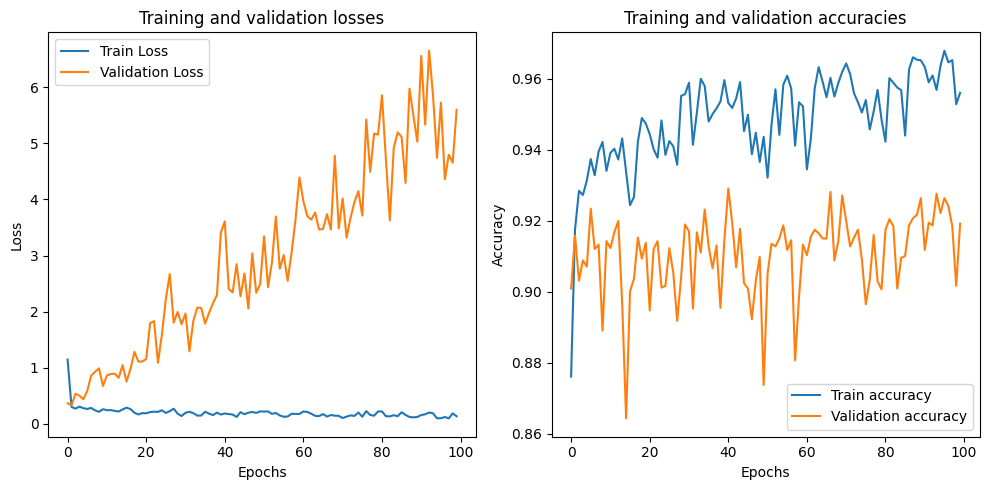

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 100

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(range(epochs), train_loss, label='Train Loss')
axs[0].plot(range(epochs), val_loss, label='Validation Loss')
axs[0].set_title("Training and validation losses")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(range(epochs), train_acc, label='Train accuracy')
axs[1].plot(range(epochs), val_acc, label='Validation accuracy')
axs[1].set_title("Training and validation accuracies")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

fig.tight_layout()

In [ ]:
class SaveModelCallBack(tf.keras.callbacks.Callback):
  def __init__(self, save_path, model):
    """
      Initialiser la classe
    """
    super().__init__()
    self.save_path = save_path
    self.model = model

  def on_epoch_end(self, epoch, logs=None):
    """
    Save the model at the end of each epoch
    """
    self.model.save_weights(filepath=self.save_path, overwrite=True)

In [ ]:
# Unfreeze the restnet backbone to train all the network now
mod.base_resnet_backbone.trainable = True
mod.base_resnet_backbone.training = True

# Préparer le modèle pour entrainement
mod.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=["accuracy"])

history1 = mod.fit(x=train_set, validation_data=val_set, epochs=90, validation_freq=1,
                   callbacks=[SaveModelCallBack(save_path="/content/drive/MyDrive/Deep Learning For EO Udemy Training/model.h5", model=mod)]
                   )

Epoch 1/90
506/506 [==============================] - 74s 83ms/step - loss: 1.3470 - accuracy: 0.5279 - val_loss: 170.6418 - val_accuracy: 0.2863
Epoch 2/90
506/506 [==============================] - 53s 104ms/step - loss: 1.2465 - accuracy: 0.5250 - val_loss: 207.1814 - val_accuracy: 0.5471
Epoch 3/90
506/506 [==============================] - 44s 86ms/step - loss: 1.0812 - accuracy: 0.5892 - val_loss: 360.2130 - val_accuracy: 0.5142
Epoch 4/90
506/506 [==============================] - 52s 103ms/step - loss: 1.0274 - accuracy: 0.6185 - val_loss: 491.8342 - val_accuracy: 0.2178
Epoch 5/90
506/506 [==============================] - 43s 85ms/step - loss: 0.9231 - accuracy: 0.6636 - val_loss: 2.0730 - val_accuracy: 0.3745
Epoch 6/90
506/506 [==============================] - 43s 85ms/step - loss: 1.3675 - accuracy: 0.5183 - val_loss: 11.1963 - val_accuracy: 0.4326
Epoch 7/90
506/506 [==============================] - 43s 86ms/step - loss: 0.9628 - accuracy: 0.6400 - val_loss: 2.3903 - va

### Matrice de confusion

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')